# Fine-Tune Whisper For Multilingual ASR with 🤗 Transformers

In this Colab, we present a step-by-step guide on how to fine-tune Whisper
for any multilingual ASR dataset using Hugging Face 🤗 Transformers. This is a
more "hands-on" version of the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper).
For a more in-depth explanation of Whisper, the Common Voice dataset and the theory behind fine-tuning, the reader is advised to refer to the blog post.

## Introduction

Whisper is a pre-trained model for automatic speech recognition (ASR)
published in [September 2022](https://openai.com/blog/whisper/) by the authors
Alec Radford et al. from OpenAI. Unlike many of its predecessors, such as
[Wav2Vec 2.0](https://arxiv.org/abs/2006.11477), which are pre-trained
on un-labelled audio data, Whisper is pre-trained on a vast quantity of
**labelled** audio-transcription data, 680,000 hours to be precise.
This is an order of magnitude more data than the un-labelled audio data used
to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this
pre-training data is multilingual ASR data. This results in checkpoints
that can be applied to over 96 languages, many of which are considered
_low-resource_.

When scaled to 680,000 hours of labelled pre-training data, Whisper models
demonstrate a strong ability to generalise to many datasets and domains.
The pre-trained checkpoints achieve competitive results to state-of-the-art
ASR systems, with near 3% word error rate (WER) on the test-clean subset of
LibriSpeech ASR and a new state-of-the-art on TED-LIUM with 4.7% WER (_c.f._
Table 8 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf)).
The extensive multilingual ASR knowledge acquired by Whisper during pre-training
can be leveraged for other low-resource languages; through fine-tuning, the
pre-trained checkpoints can be adapted for specific datasets and languages
to further improve upon these results. We'll show just how Whisper can be fine-tuned
for low-resource languages in this Colab.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

The Whisper checkpoints come in five configurations of varying model sizes.
The smallest four are trained on either English-only or multilingual data.
The largest checkpoints are multilingual only. All 11 of the pre-trained checkpoints
are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper). The
checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


For demonstration purposes, we'll fine-tune the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
As for our data, we'll train and evaluate our system on a low-resource language
taken from the [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
dataset. We'll show that with as little as 8 hours of fine-tuning data, we can achieve
strong performance in this language.

------------------------------------------------------------------------

\\({}^1\\) The name Whisper follows from the acronym “WSPSR”, which stands for “Web-scale Supervised Pre-training for Speech Recognition”.

## Prepare Environment

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 23 02:31:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model, and
`tensorboard` to log our metrics. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [2]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
   

We strongly advise you to upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training. The Hub provides:
- Integrated version control: you can be sure that no model checkpoint is lost during training.
- Tensorboard logs: track important metrics over the course of training.
- Model cards: document what a model does and its intended use cases.
- Community: an easy way to share and collaborate with the community!

Linking the notebook to the Hub is straightforward - it simply requires entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

Using 🤗 Datasets, downloading and preparing data is extremely simple.
We can download and prepare the Common Voice splits in just one line of code.

First, ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_11_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0). Once you have accepted the terms, you will have full access to the dataset and be able to download the data locally.

Since Hindi is very low-resource, we'll combine the `train` and `validation`
splits to give approximately 8 hours of training data. We'll use the 4 hours
of `test` data as our held-out test set:

In [4]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "rw", split="validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "rw", split="test", use_auth_token=True)

print(common_voice)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You 

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 11757it [00:00, 117557.22it/s]
Reading metadata...: 26921it [00:00, 137600.46it/s]
Reading metadata...: 41037it [00:00, 139217.18it/s]
Reading metadata...: 54959it [00:00, 135868.07it/s]
Reading metadata...: 68558it [00:00, 135123.08it/s]
Reading metadata...: 82286it [00:00, 135839.27it/s]
Reading metadata...: 95876it [00:00, 133407.39it/s]
Reading metadata...: 110230it [00:00, 136568.99it/s]
Reading metadata...: 123901it [00:00, 136139.06it/s]
Reading metadata...: 137524it [00:01, 131530.99it/s]
Reading metadata...: 150836it [00:01, 132000.13it/s]
Reading metadata...: 164152it [00:01, 132329.56it/s]
Reading metadata...: 177404it [00:01, 126633.28it/s]
Reading metadata...: 191162it [00:01, 129800.05it/s]
Reading metadata...: 204196it [00:01, 129312.24it/s]
Reading metadata...: 217439it [00:01, 130226.20it/s]
Reading metadata...: 230943it [00:01, 131646.75it/s]
Reading metadata...: 244857it [00:01, 133868.57it/s]
Reading meta

Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 15987it [00:00, 118667.43it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 16213it [00:00, 122614.51it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 14516it [00:00, 145146.64it/s]
Reading metadata...: 29821it [00:00, 149788.86it/s]
Reading metadata...: 47295it [00:00, 154538.60it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 13292it [00:00, 132912.52it/s]
Reading metadata...: 27889it [00:00, 140589.35it/s]
Reading metadata...: 42337it [00:00, 142355.38it/s]
Reading metadata...: 56647it [00:00, 142645.09it/s]
Reading metadata...: 71085it [00:00, 143259.02it/s]
Reading metadata...: 85411it [00:00, 142847.32it/s]
Reading metadata...: 99696it [00:00, 141292.36it/s]
Reading metadata...: 114286it [00:00, 142744.62it/s]
Reading metadata...: 128660it [00:00, 142944.66it/s]
Reading metadata...: 143141it [00:01, 143514.90it/s]
Reading metadata...: 157495it [00:01, 142705.18it/s]
Reading metadata...: 171768it [00:01, 139908.79it/s]
Reading metadata...: 185771it [00:01, 137542.36it/s]
Reading metadata...: 199539it [00:01, 137121.81it/s]
Reading metadata...: 227748it [00:01, 141183.03it/s]
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 15987
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 16213
    })
})


Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`). Common Voice contains additional
metadata information, such as `accent` and `locale`, which we can disregard for ASR.
Keeping the notebook as general as possible, we only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [5]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 15987
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 16213
    })
})


In [ ]:
# reduce the dataset
# common_voice =DatasetDict(
#     {
#         "train": common_voice['train'].select(range(100)),
#         "test": common_voice['test'].select(range(20)),
#     }
# )

In [6]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 15987
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 16213
    })
})

## Prepare Feature Extractor, Tokenizer and Data

The ASR pipeline can be de-composed into three stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.

We'll go through details for setting-up the feature extractor and tokenizer one-by-one!

### Load WhisperFeatureExtractor

The Whisper feature extractor performs two operations:
1. Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [7]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [8]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language=None, task="transcribe")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Combine To Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [9]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language=None, task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Prepare Data

Let's print the first example of the Common Voice dataset to see
what form the data is in:

In [10]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/4425feb8ae553c0aa901cf121a8325b3cff37d617fedca60a2a49f3621914a21/rw_dev_0/common_voice_rw_22528913.mp3', 'array': array([ 0.00000000e+00,  1.69610449e-15,  4.76150762e-15, ...,
       -5.55775841e-07,  9.44283238e-06,  1.75083787e-05]), 'sampling_rate': 48000}, 'sentence': 'dore ko hari abashakaga kumubona ku nshuro ya mbere'}


Since
our input audio is sampled at 48kHz, we need to _downsample_ it to
16kHz prior to passing it to the Whisper feature extractor, 16kHz being the sampling rate expected by the Whisper model.

We'll set the audio inputs to the correct sampling rate using dataset's
[`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column)
method. This operation does not change the audio in-place,
but rather signals to `datasets` to resample audio samples _on the fly_ the
first time that they are loaded:

In [11]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Re-loading the first audio sample in the Common Voice dataset will resample
it to the desired sampling rate:

In [12]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/4425feb8ae553c0aa901cf121a8325b3cff37d617fedca60a2a49f3621914a21/rw_dev_0/common_voice_rw_22528913.mp3', 'array': array([-2.47382559e-10, -1.74622983e-10, -7.27595761e-11, ...,
        1.38110772e-06,  1.17757008e-05, -9.57923476e-07]), 'sampling_rate': 16000}, 'sentence': 'dore ko hari abashakaga kumubona ku nshuro ya mbere'}


Now we can write a function to prepare our data ready for the model:
1. We load and resample the audio data by calling `batch["audio"]`. As explained above, 🤗 Datasets performs any necessary resampling operations on the fly.
2. We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
3. We encode the transcriptions to label ids through the use of the tokenizer.

In [13]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

We can apply the data preparation function to all of our training examples using dataset's `.map` method. The argument `num_proc` specifies how many CPU cores to use. Setting `num_proc` > 1 will enable multiprocessing. If the `.map` method hangs with multiprocessing, set `num_proc=1` and process the dataset sequentially.

In [14]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

Map (num_proc=2):   0%|          | 0/15987 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/16213 [00:00<?, ? examples/s]

## Training and Evaluation

Now that we've prepared our data, we're ready to dive into the training pipeline.
The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)
will do much of the heavy lifting for us. All we have to do is:

- Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.

- Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

- Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation.

- Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule.

Once we've fine-tuned the model, we will evaluate it on the test data to verify that we have correctly trained it
to transcribe speech in Hindi.

### Load a Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper `small` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [15]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

We can disable the automatic language detection task performed during inference, and force the model to generate in Hindi. To do so, we set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config. We'll also set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None, since this was the legacy way of setting the language and
task arguments:

In [25]:
model.generation_config.language = "swahili"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

### Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the
feature extractor and the tokenizer operations:

In [26]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [27]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [28]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [29]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [30]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-rw",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    # push_to_hub=True,
    push_to_hub=False,
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [31]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [32]:
processor.save_pretrained(training_args.output_dir)

[]

### Training

Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab. If using this Google Colab directly to
fine-tune a Whisper model, you should make sure that training isn't
interrupted due to inactivity. A simple workaround to prevent this is
to paste the following code into the console of this tab (_right mouse click_
-> _inspect_ -> _Console tab_ -> _insert code_).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for the given training configuration is approximately 15.8GB.
Depending on the GPU allocated to the Google Colab, it is possible that you will encounter a CUDA `"out-of-memory"` error when you launch training.
In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

To launch training, simply execute:

In [33]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
1000,0.695200,0.991951,70.502285
2000,0.477100,0.926026,68.362372
3000,0.313200,0.950552,68.073194
4000,0.202500,0.991832,68.727057


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint

TrainOutput(global_step=4000, training_loss=0.4390544400215149, metrics={'train_runtime': 53800.5894, 'train_samples_per_second': 1.19, 'train_steps_per_second': 0.074, 'total_flos': 1.845445917966336e+19, 'train_loss': 0.4390544400215149, 'epoch': 4.0})

Our best WER is 32.0% - not bad for 8h of training data! We can make our model more accessible on the Hub with appropriate tags and README information.
You can change these values to match your dataset, language and model
name accordingly:

In [34]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Whisper Small Kinyarwanda",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command and save the preprocessor object we created:

In [35]:
!pip install transformers --q
!pip install sentencepiece --q

In [36]:
!pip install huggingface_hub --q


In [38]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write)

In [39]:
trainer.push_to_hub('NMutangana/KinyarwandaModel')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


events.out.tfevents.1713843228.0627c35818b0.402.0:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

events.out.tfevents.1713870097.0627c35818b0.402.1:   0%|          | 0.00/41.8k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/NMutangana/whisper-small-rw/commit/5cab1fb031caae07296218c2455b3015f0e5752b', commit_message='NMutangana/KinyarwandaModel', commit_description='', oid='5cab1fb031caae07296218c2455b3015f0e5752b', pr_url=None, pr_revision=None, pr_num=None)

## Building a Demo

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

In [40]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="NMutangana/whisper-small-rw")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="Whisper Small Kinyarwanda",
    description="Realtime demo for Kinyarwanda speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

config.json:   0%|          | 0.00/2.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5a9e58f53da21a814b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [41]:
import torch
from transformers import pipeline
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipe = pipeline(model="NMutangana/whisper-small-rw")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# sample = ds[0]["audio"]

# prediction = pipe(sample.copy(), batch_size=8)["text"]

# # we can also return timestamps for the predictions
# prediction = pipe(sample.copy(), batch_size=8, return_timestamps=True)["chunks"]


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
import numpy as np

## Closing Remarks

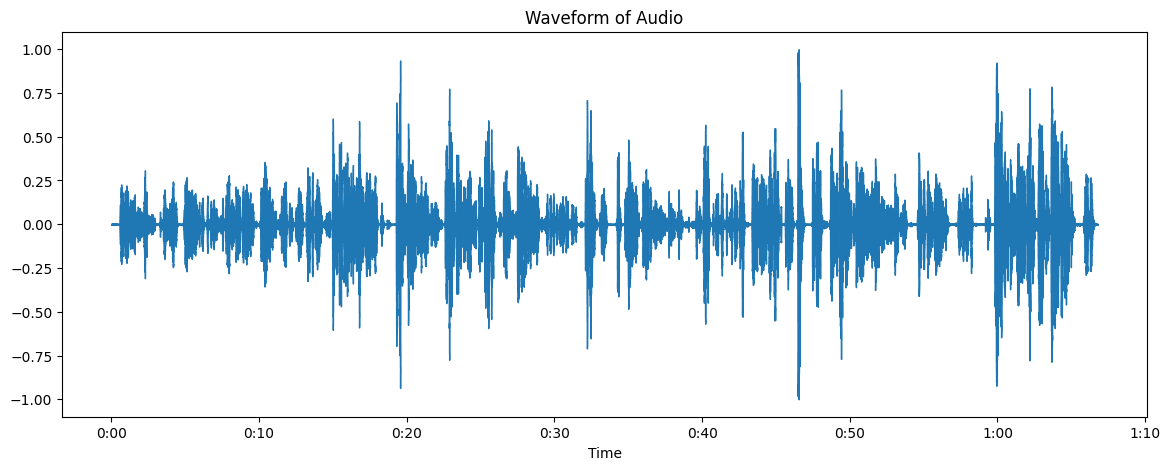

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file as a floating point time series
audio_path = '/content/WhatsApp Ptt 2024-04-21 at 13.53.53.ogg'
audio, sample_rate = librosa.load(audio_path, sr=None)  # sr (sample rate) set to None to use the native sample rate

# Display the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sample_rate)
plt.title('Waveform of Audio')
plt.show()


In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text
transcribe(audio)

' Ndumwundo nubwo nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora nshobora N

In this blog, we covered a step-by-step guide on fine-tuning Whisper for multilingual ASR
using 🤗 Datasets, Transformers and the Hugging Face Hub. For more details on the Whisper model, the Common Voice dataset and the theory behind fine-tuning, refere to the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper). If you're interested in fine-tuning other
Transformers models, both for English and multilingual ASR, be sure to check out the
examples scripts at [examples/pytorch/speech-recognition](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-recognition).